In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 6, 6), datetime.date(2022, 6, 4))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=M">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'cmu cif min cxh mmt mfm mfv mtg mgp mgm mho mnso mogu mp mplx mrc '
    'msa msm msci msgn mvcd mvc myte mac cli mfd mgu mic m mcn msg '
    'msge msgs mmp mga mx mgy opa mhla mhnc main megi mmd mnk hyf manu '
    'mtw mfs mn man mfc mro mpc mcs mmi mhg mpx hzo mkl mkfg vac mmc '
    'mlm mtz mas mit door ma mtdr mtrn matx mlp maxr mxl mec mkc mdr mcd'
)
missing = (
    'mvc mhg msgn cli mfs mnk hyf mdr msg'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  69 of 69 completed


,cmu,cif,min,cxh,mmt,mfm,mfv,mtg,mgp,mgm,...,ma,mtdr,mtrn,matx,mlp,maxr,mxl,mec,mkc,mcd
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-06,1.195543,2.823366,6.342363,27.5,9.02,25.899637,39.660919,32.894348,10.895938,29.355244,...,2.361039,20.388023,9.917709,16.320000,NaN,9.38,4.47,NaN,NaN,24.366133
2012-06-07,1.219533,2.806393,6.366271,27.5,8.76,25.282986,39.257679,32.369190,10.779326,29.038631,...,2.314193,20.215242,9.873235,16.309999,NaN,9.03,4.48,NaN,NaN,24.510206
2012-06-08,1.227531,2.783760,6.420071,27.5,8.93,25.781841,39.337009,33.050152,10.961234,28.989920,...,2.342301,20.324369,9.686443,15.910000,NaN,9.34,4.53,NaN,NaN,24.942427
2012-06-11,1.239525,2.806393,6.408117,27.5,8.66,25.192905,39.081085,31.890203,10.849294,28.381062,...,2.211132,19.687805,8.921492,15.330000,NaN,8.87,4.58,NaN,NaN,24.546227
2012-06-12,1.232276,2.805254,6.397906,27.5,9.16,25.580912,39.450329,31.913279,11.199120,28.933098,...,2.342301,20.460775,9.366232,15.590000,NaN,9.34,4.67,NaN,NaN,24.105003


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
47,mmi,1.281644
54,mlm,1.054895
39,manu,1.026872
6,mfv,0.958401
14,mplx,0.764146
34,mhla,0.752798
11,mnso,0.741042
25,m,0.714630
48,mpx,0.712912
37,megi,0.711531


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858
5,hhs,2.406309
6,bxsl,2.249160
7,APSG,2.178348
8,dwin,1.886962
9,irs,1.757207


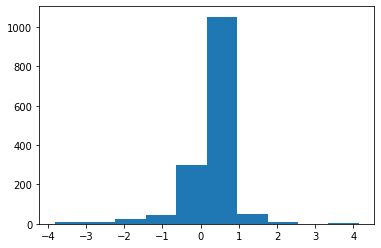

In [12]:
plt.hist(sharpes.sharpe);

In [13]:
sharpes.loc[sharpes.stock == 'CBX', :]

,stock,sharpe


In [14]:
omit = ('eg')
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [15]:
sharpes.to_csv('sharpes.csv', index=False)

In [16]:
sharpes.shape

(1506, 2)

In [17]:
MIX = sharpes.stock.unique().tolist()[:200]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  200 of 200 completed
(2518, 200)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-06-06  31.807751  4.408025  17.440697 NaN  7.446387  NaN  24.474443   
2012-06-07  31.543327  4.402632  16.517218 NaN  7.589504  NaN  24.444012   
2012-06-08  31.611563  4.377849  16.776445 NaN  7.511439  NaN  24.230989   
2012-06-11  31.099775  4.223320  16.444313 NaN  7.507103  NaN  24.109262   
2012-06-12  31.560379  4.313705  16.606321 NaN  7.567820  NaN  24.291853   

                                    ...                               \
                 AEG       AEL AFI  ...       MUE RERE SAVN SUNY TCS   
Date                                ...                                
2012-06-06  2.762222  9.504830 NaN  ...  8.502667  NaN  NaN  NaN NaN   
2012-06-07  2.717151  9.559352 NaN  ...  8.485279  NaN  NaN  NaN NaN   
2012-06-08  2.710712  9.632047 NaN  ...  8.520055  NaN  NaN  NaN NaN   
2012-06-11  2.614131  9.432137 NaN  ...  8.549037  NaN  NaN  NaN NaN   
2012-06-12  2.614131  9.486657 NaN  ...  8.531650  NaN  NaN  NaN NaN   

                                                      
                 TFG         UAN       VLT WNNR XPOA  
Date                                                  
2012-06-06  4.140134  110.574890  7.397816  NaN  NaN  
2012-06-07  4.128553  114.974533  7.415399  NaN  NaN  
2012-06-08  4.088019  115.981720  7.441772  NaN  NaN  
2012-06-11  4.011415  111.211006  7.507707  NaN  NaN  
2012-06-12  4.011415  109.037666  7.481331  NaN  NaN  

[5 rows x 200 columns]

In [18]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2518, 112)


,ASAN,efc,lly,chmt,bxsl,APSG,dwin,iff,axh,fmc,...,dk,hcp,bme,esnt,efx,enfn,eqha,megi,fra,APO
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-06,31.807751,4.408025,17.440697,7.446387,24.474443,2.762222,9.504830,15.731170,4.558800,54.844414,...,9.646485,2.683418,14.736019,60.121025,19.216724,3.724362,8.502667,4.140134,110.574890,7.397816
2012-06-07,31.543327,4.402632,16.517218,7.589504,24.444012,2.717151,9.559352,15.342130,4.576201,54.469269,...,9.460262,2.683418,14.649201,60.084972,19.316996,3.862301,8.485279,4.128553,114.974533,7.415399
2012-06-08,31.611563,4.377849,16.776445,7.511439,24.230989,2.710712,9.632047,15.561589,4.541400,55.269562,...,9.559580,2.718519,14.753383,60.878288,19.411366,3.972653,8.520055,4.088019,115.981720,7.441772
2012-06-11,31.099775,4.223320,16.444313,7.507103,24.109262,2.614131,9.432137,15.212449,4.480502,54.719349,...,9.460262,2.671716,14.759168,60.292297,19.440857,3.841610,8.549037,4.011415,111.211006,7.507707
2012-06-12,31.560379,4.313705,16.606321,7.567820,24.291853,2.614131,9.486657,16.020454,4.515301,55.344589,...,9.559580,2.709467,14.973325,60.211170,19.718081,4.034725,8.531650,4.011415,109.037666,7.481331


In [19]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

calx  : 0.05104
hrl   : 0.02978
glop  : 0.03105
gnw   : 0.02847
eea   : 0.12703
hubb  : 0.01911
AVD   : 0.06668
expr  : 0.07082
RERE  : 0.07186
ABEV  : 0.00053
htfa  : 0.0438
dlx   : 0.00203
tcs   : 0.02703
xpoa  : 0.18418
tfg   : 0.05787
megi  : 0.18872


In [20]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 19.4%
Annual volatility: 12.9%
Sharpe Ratio: 1.36


In [21]:
s1

1.3557043591270301

In [22]:
cla = CLA(mu, s)
min_vol_w = cla.min_volatility()
cleaned_weights = cla.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

dhi   : 0.00837
ATA   : 0.01066
eea   : 0.01132
clw   : 0.03228
fnv   : 0.00199
AEG   : 0.00781
expr  : 0.02735
cia   : 0.1313
RERE  : 0.03428
iacc  : 0.04187
vlt   : 0.11705
ABEV  : 0.00706
cto   : 0.00324
chn   : 0.00083
htfa  : 0.03738
gmed  : 0.05458
WNNR  : 0.06244
mue   : 0.00317
xpoa  : 0.00902
suny  : 0.00144
bme   : 0.03412
eqha  : 0.13381
megi  : 0.201
APO   : 0.02762


In [23]:
r, v, s = cla.portfolio_performance(verbose=True)

Expected annual return: 7.3%
Annual volatility: 8.3%
Sharpe Ratio: 0.64


In [24]:
r, v, s

(0.0730892985501127, 0.08329097989331913, 0.6373955333231834)